## Import Dependencies

In [34]:
import os
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Wedge
from mplsoccer import Pitch

## Data Preprocessing

In [35]:
# 12 rows x 16 columns grid
XT_GRID = np.array([
    [0.001, 0.002, 0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.009, 0.011, 0.013, 0.016, 0.017, 0.017, 0.016],
    [0.002, 0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.012, 0.015, 0.018, 0.021, 0.020, 0.021],
    [0.002, 0.003, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.009, 0.010, 0.013, 0.016, 0.021, 0.025, 0.027, 0.024],
    [0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.011, 0.014, 0.018, 0.024, 0.029, 0.039, 0.031],
    [0.003, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.011, 0.014, 0.019, 0.027, 0.055, 0.091, 0.071],
    [0.004, 0.004, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.012, 0.014, 0.019, 0.033, 0.077, 0.142, 0.332],
    [0.004, 0.004, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.012, 0.014, 0.020, 0.034, 0.085, 0.134, 0.320],
    [0.004, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.012, 0.014, 0.020, 0.028, 0.062, 0.095, 0.085],
    [0.002, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.011, 0.014, 0.018, 0.025, 0.035, 0.042, 0.033],
    [0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.011, 0.013, 0.017, 0.021, 0.026, 0.026, 0.022],
    [0.002, 0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.009, 0.010, 0.013, 0.016, 0.019, 0.021, 0.020, 0.020],
    [0.001, 0.002, 0.002, 0.003, 0.004, 0.004, 0.005, 0.007, 0.008, 0.009, 0.012, 0.014, 0.016, 0.018, 0.017, 0.017]
])

# Pitch Dimensions
SB_WIDTH = 120
SB_HEIGHT = 80
ROWS, COLS = XT_GRID.shape

In [36]:
def _load_events_raw(match_id, base_path):
    event_path = os.path.join(base_path, f"events/{match_id}.json")
    with open(event_path, "r") as f:
        events_raw = json.load(f)
    return events_raw

In [37]:
def _extract_shot_features(df_events):
    df_shots = df_events[df_events["type_name"] == "Shot"].copy()
    
    if not df_shots.empty:
        target_cols = {
            'id': 'shot_id_temp',
            'shot_statsbomb_xg': 'assisted_shot_xg',
            'shot_outcome_name': 'assisted_shot_outcome'
        }
        return df_shots[list(target_cols.keys())].rename(columns=target_cols)
    
    # Return empty structure if no shots found
    return pd.DataFrame(columns=['shot_id_temp', 'assisted_shot_xg', 'assisted_shot_outcome'])

The function `load_passes` serves as a standardized processing engine to convert raw StatsBomb JSON events into an analysis-ready format. It follows a multi-stage pipeline designed for modularity and future research extensibility.

| **Stage** | **Process** | **Research Utility** |
|---|---|---|
| Feature Extraction | Isolate "Pass" events and utilize a helper function to retrieve associated Shot xG and outcomes. | Allows for "Pass-to-Shot" dependency analysis and Shot-Assist quality metrics. |
| Attribute Filtering | Selects a standardized subset of tactical markers (e.g., `pass_cross`, `pass_technique_name`). | Maintains a lightweight DataFrame while preserving latent variables for future categorical analysis. |
| Coordinate Normalization | Unpacks nested location lists into discrete (x,y) and (end_x,end_y) vectors. | Essential for heatmapping, distance calculations, and geometric formation analysis. |
| Spatial Threat Mapping | Vectorized lookup against a 12x16 xT Matrix to calculate the Threat Delta (ΔxT). | Quantifies the progressive value of possession beyond traditional completion percentages. |

In [38]:
def load_passes(match_id, base_path):
    events_raw = _load_events_raw(match_id, base_path)
    df_events = pd.json_normalize(events_raw, sep="_")
    
    # Extract and Format Shot Data 
    df_shots = _extract_shot_features(df_events)

    # Filter Passes & Select Columns
    df_passes = df_events[df_events["type_name"] == "Pass"].copy()
    
    desired_columns = [
        "id", "period", "timestamp", "minute", "second","team_name", "player_id", "player_name", 
        "pass_recipient_id", "pass_recipient_name", "location", "pass_end_location",
        "pass_length", "pass_angle", "pass_height_name", "pass_assisted_shot_id", 
        "pass_backheel", "pass_deflected", "pass_miscommunication", "pass_cross", 
        "pass_cut_back", "pass_switch", "pass_shot_assist", "pass_goal_assist", 
        "pass_body_part_name", "pass_type_name", "pass_outcome_name", "pass_technique_name"
    ]
    
    existing_cols = [col for col in desired_columns if col in df_passes.columns]
    df_passes = df_passes[existing_cols].copy()

    # Merges Shots and Passes
    if "pass_assisted_shot_id" in df_passes.columns:
        df_passes = df_passes.merge(df_shots, left_on='pass_assisted_shot_id', right_on='shot_id_temp', how='left').drop(columns=['shot_id_temp'])
    else:
        df_passes[['assisted_shot_xg', 'assisted_shot_outcome']] = None

    # Unpack Coordinates
    if "location" in df_passes.columns:
        df_passes[['x', 'y']] = pd.DataFrame(df_passes['location'].tolist(), index=df_passes.index)
        df_passes[['end_x', 'end_y']] = pd.DataFrame(df_passes['pass_end_location'].tolist(), index=df_passes.index)

    # Calculate Expected Threat (xT)
    if all(col in df_passes.columns for col in ['x', 'y', 'end_x', 'end_y']):
        x_bins = np.clip(np.floor(df_passes['x'] / SB_WIDTH * COLS).astype(int), 0, COLS - 1)
        y_bins = np.clip(np.floor(df_passes['y'] / SB_HEIGHT * ROWS).astype(int), 0, ROWS - 1)
        
        end_x_bins = np.clip(np.floor(df_passes['end_x'] / SB_WIDTH * COLS).astype(int), 0, COLS - 1)
        end_y_bins = np.clip(np.floor(df_passes['end_y'] / SB_HEIGHT * ROWS).astype(int), 0, ROWS - 1)

        start_xt = XT_GRID[y_bins, x_bins]
        end_xt = XT_GRID[end_y_bins, end_x_bins]
        df_passes['pass_xt'] = end_xt - start_xt

    return df_passes

We load lineups to map unique StatsBomb identifiers to descriptive player attributes, ensuring tbetter visualizations. 

In [39]:
def load_lineups(match_id, base_path):
    lineup_path = os.path.join(base_path, f"lineups/{match_id}.json")
    
    with open(lineup_path, "r") as f:
        lineups_raw = json.load(f)
        
    lineup_list = []
    for team in lineups_raw:
        team_name = team["team_name"]
        for player in team["lineup"]:
            player_info = {
                "team_name": team_name,
                "player_id": player["player_id"],
                "player_name": player["player_name"],
                "player_nickname": player.get("player_nickname"),
                "jersey_number": player["jersey_number"],
                "country": player["country"]["name"]
            }
            lineup_list.append(player_info)
            
    df_lineups = pd.DataFrame(lineup_list)
    return df_lineups

In constructing a passing network, the primary objective is to visualize the intended tactical structure of a team. To ensure the integrity of this visualization, we apply a "First Sub" cutoff logic, which restricts the dataset to the period between kick-off and the first structural change (substitution or dismissal).

Therefore, here we made a "chronological governer" of the data. It establishes the timeline of the match to determine exactly when each player was active.

| **Component** | **Logic Applied** |
| --- | --- |
| Starters | Identifies the 22 players in the `Starting XI` events and initializes their start time to 00:00. |
| Substitutions | Triggers a dual update: records the exit time for the player going off and initializes a new entry for the player coming on. |
| Disciplinary Exits | Scans for `Red Card` or `Second Yellow` events to force an early exit time for the penalized player. |
| Match Ceiling | Identifies the final recorded event time to serve as the default exit for all players still on the pitch. |

In [40]:
def load_appearances(match_id, base_path):
    events_raw = _load_events_raw(match_id, base_path)
    df_events = pd.json_normalize(events_raw, sep="_")
    
    # Match End Ceiling
    max_idx = df_events['minute'].idxmax()
    match_end = {
        'minute': df_events.loc[max_idx, 'minute'],
        'second': df_events.loc[max_idx, 'second'],
        'period': df_events.loc[max_idx, 'period'],
        'timestamp': df_events.loc[max_idx, 'timestamp']
    }
    
    appearances = {}
    
    # A: Starters
    starters = df_events[df_events['type_name'] == 'Starting XI']
    match_start_ts = df_events.loc[0, 'timestamp']
    
    for _, event in starters.iterrows():
        raw_event = [e for e in events_raw if e['id'] == event['id']][0]
        for player in raw_event['tactics']['lineup']:
            p_id = player['player']['id']
            appearances[p_id] = {
                'player_name': player['player']['name'],
                'team_name': event['team_name'],
                'start_minute': 0, 'start_second': 0, 'start_period': 1,
                'start_timestamp': match_start_ts,
                'end_minute': match_end['minute'], 'end_second': match_end['second'],
                'end_period': match_end['period'], 'end_timestamp': match_end['timestamp'],
                'status': 'Starter'
            }

    # B: Substitutions
    subs = df_events[df_events['type_name'] == 'Substitution']
    for _, event in subs.iterrows():
        p_off = event['player_id']
        p_in = event['substitution_replacement_id']
        
        # Player OFF: Update End Time
        if p_off in appearances:
            appearances[p_off].update({
                'end_minute': event['minute'], 'end_second': event['second'],
                'end_period': event['period'], 'end_timestamp': event['timestamp']
            })
            
        # Player ON: Create New Entry
        appearances[p_in] = {
            'player_name': event['substitution_replacement_name'],
            'team_name': event['team_name'],
            'start_minute': event['minute'], 'start_second': event['second'],
            'start_period': event['period'], 'start_timestamp': event['timestamp'],
            'end_minute': match_end['minute'], 'end_second': match_end['second'],
            'end_period': match_end['period'], 'end_timestamp': match_end['timestamp'],
            'status': 'Sub'
        }

    # C: Red Cards
    card_cols = ['bad_behaviour_card_name', 'foul_committed_card_name']
    valid_card_cols = [c for c in card_cols if c in df_events.columns]
    
    for col in valid_card_cols:
        reds = df_events[df_events[col].isin(['Red Card', 'Second Yellow'])]
        for _, event in reds.iterrows():
            if event['player_id'] in appearances:
                appearances[event['player_id']].update({
                    'end_minute': event['minute'], 'end_second': event['second'],
                    'end_period': event['period'], 'end_timestamp': event['timestamp']
                })

    # D: Match Ceiling
    df_app = pd.DataFrame.from_dict(appearances, orient='index').reset_index().rename(columns={'index': 'player_id'})
    df_app['mins_played'] = df_app['end_minute'] - df_app['start_minute']
    
    return df_app

In [41]:
def prepare_filtered_passes(base_path, match_id, team_name=None):
    # Load the three core modules
    df_passes = load_passes(match_id, base_path)
    df_app = load_appearances(match_id, base_path)
    df_lineups = load_lineups(match_id, base_path)
    
    #  Resolve Team Name
    if team_name is None:
        team_name = df_lineups['team_name'].unique()[0]
    
    # Identify Starters and their earliest exit time
    mask_starters = (df_app['team_name'] == team_name) & (df_app['status'] == 'Starter')
    df_starters = df_app[mask_starters].copy()
    
    # Create time tuples (Period, Minute, Second) to find the exact cutoff
    df_starters['exit_time_tuple'] = list(zip(
        df_starters['end_period'], 
        df_starters['end_minute'], 
        df_starters['end_second']
    ))
    earliest_exit = df_starters['exit_time_tuple'].min()
    
    # Filter passes by Team, Player ID (Starters), and Time
    starter_ids = df_starters['player_id'].tolist()
    pass_time_tuples = list(zip(df_passes['period'], df_passes['minute'], df_passes['second']))
    is_before_cutoff = [t < earliest_exit for t in pass_time_tuples]
    
    df_passes_clean = df_passes[
        (df_passes['team_name'] == team_name) &
        (df_passes['player_id'].isin(starter_ids)) &
        (pd.Series(is_before_cutoff, index=df_passes.index))
    ].copy()
    
    return df_passes_clean

## Plot the Passing Network

In [42]:
def calculate_average_locations(df_passes_clean):
    # Metric Columns
    df_passes_clean['is_success'] = df_passes_clean['pass_outcome_name'].isna().astype(int)
    df_passes_clean['pass_xt'] = df_passes_clean.get('pass_xt', 0).fillna(0)

    # Main Aggregation
    df_nodes = df_passes_clean.groupby(['player_id', 'player_name']).agg({
        'x': 'mean',
        'y': 'mean',
        'id': 'count',              
        'is_success': 'sum',       
        'pass_xt': 'sum'            
    }).reset_index()

    df_nodes.rename(columns={'id': 'pass_count', 'is_success': 'success_count', 'pass_xt': 'total_xt'}, inplace=True)
    df_nodes['success_rate'] = df_nodes['success_count'] / df_nodes['pass_count']

    # Calculate Average Angle of FAILED Passes
    df_failed = df_passes_clean[df_passes_clean['is_success'] == 0].copy()
    
    if not df_failed.empty:
        # Convert radians to unit vectors (x, y) to handle circular averaging
        df_failed['fail_cos'] = np.cos(df_failed['pass_angle'])
        df_failed['fail_sin'] = np.sin(df_failed['pass_angle'])
        
        # Group by player and average the vectors
        fail_dirs = df_failed.groupby('player_id')[['fail_cos', 'fail_sin']].mean()
        
        # Convert back to degrees (StatsBomb 0 is East, 90 is North - matches MPL)
        fail_dirs['avg_fail_angle'] = np.degrees(np.arctan2(fail_dirs['fail_sin'], fail_dirs['fail_cos']))
        
        # Merge back to nodes
        df_nodes = df_nodes.merge(fail_dirs['avg_fail_angle'], on='player_id', how='left')
    else:
        df_nodes['avg_fail_angle'] = 0 # Default if match has 0 errors (rare)

    # Fill NaN angles (players with 100% success have no fail angle) with 0
    df_nodes['avg_fail_angle'] = df_nodes['avg_fail_angle'].fillna(0)
    
    return df_nodes

In [43]:
def calculate_edges(df_passes_clean):
    # Group by Passer and Recipient to get raw directional counts
    pass_counts = df_passes_clean.groupby(['player_id', 'pass_recipient_id']).size().reset_index(name='pass_count')
    
    # Create a "Sorted Pair" column to treat A->B and B->A as the same link
    pass_counts['pair_key'] = pass_counts.apply(
        lambda x: tuple(sorted([x['player_id'], x['pass_recipient_id']])), axis=1
    )
    
    # Aggregate by this new pair key to get total interaction volume
    df_edges = pass_counts.groupby('pair_key')['pass_count'].sum().reset_index()
    
    # Unpack the pair key back into two columns for plotting
    df_edges[['player1_id', 'player2_id']] = pd.DataFrame(df_edges['pair_key'].tolist(), index=df_edges.index)
    
    return df_edges

In [44]:
def plot_passing_network(df_clean_passes, team_name="Home Team"):
    df_nodes = calculate_average_locations(df_clean_passes)
    df_edges = calculate_edges(df_clean_passes)

    pitch = Pitch(
        pitch_type='statsbomb', 
        pitch_color='black', 
        line_color='white'   
    )
    fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
    fig.set_facecolor("black")
    
    # Draw Edges 
    for _, row in df_edges.iterrows():
        try:
            p1 = df_nodes.loc[df_nodes['player_id'] == row['player1_id']].iloc[0]
            p2 = df_nodes.loc[df_nodes['player_id'] == row['player2_id']].iloc[0]
        except IndexError:
            continue
        
        if row['pass_count'] < 3:
            continue
            
        line_width = row['pass_count'] * 0.5
        pitch.lines(p1['x'], p1['y'], p2['x'], p2['y'],
                    ax=ax, lw=line_width, color='white', alpha=0.2, zorder=1)

    colors = ["#8B4513", "#FF8C00", "#FFFFE0"] 
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("threat_map", colors)
    
    MAX_RADIUS = 3.5 
    max_passes = df_nodes['pass_count'].max()
    max_xt = df_nodes['total_xt'].max()
    vmax_val = max(max_xt, 0.05) # Lower vmax makes colors more intense for lower xT
    norm = mcolors.Normalize(vmin=0, vmax=vmax_val)

    # Draw Nodes 
    for i, row in df_nodes.iterrows():
        radius = (row['pass_count'] / max_passes) * MAX_RADIUS
        fail_ratio = 1.0 - row['success_rate']
        fail_sweep = fail_ratio * 360
        node_color = custom_cmap(norm(row['total_xt']))
        
        if fail_ratio == 0:
            circle = plt.Circle((row['x'], row['y']), radius, color=node_color, ec='white', lw=0.5, zorder=3)
            ax.add_patch(circle)
        else:
            center_angle = row['avg_fail_angle']
            theta1_fail = center_angle - (fail_sweep / 2)
            theta2_fail = center_angle + (fail_sweep / 2)
            
            wedge_fail = Wedge(
                center=(row['x'], row['y']), r=radius, 
                theta1=theta1_fail, theta2=theta2_fail, 
                facecolor='white', alpha=0.2, edgecolor='none', zorder=2
            )
            ax.add_patch(wedge_fail)

            wedge_success = Wedge(
                center=(row['x'], row['y']), r=radius, 
                theta1=theta2_fail, theta2=theta1_fail + 360, 
                facecolor=node_color, edgecolor='white', linewidth=0.8, zorder=3
            )
            ax.add_patch(wedge_success)

        # Annotation
        pitch.annotate(row['player_name'], xy=(row['x'], row['y'] - radius - 2.5), 
                       ax=ax, ha='center', va='top', fontsize=9, 
                       color='white', zorder=4)

    cbar_ax = fig.add_axes([0.93, 0.2, 0.015, 0.6]) 
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=cbar_ax)
    cbar.ax.yaxis.set_tick_params(color='white', labelsize=10)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    cbar.set_label('Cumulative Expected Threat (xT)', color='white', fontsize=12, labelpad=15)
    cbar.outline.set_edgecolor('white')

    ax.set_title(f"{team_name.upper()} - PASSING NETWORK", 
                 fontsize=28, color='white', pad=10)
    
    plt.show()

The network encodes four distinct data dimensions into every node and edge, allowing for an immediate assessment of a team's tactical "health."

| **Component** | **Visual Logic** | **Tactical Interpretation** | 
| --- | --- | --- |
| Node Size | Scaled by Total Pass Attempts. | Identifies the team's "conductors" (high volume) vs. "finishers" (low volume). |
| Pie Chart | A white/grey wedge representing Completion %. | Visualizes the reliability of the player; the larger the "crack," the higher the turnover rate. |
| Crack Direction | Faces the Average Angle of failed passes. | Pinpoints directional vulnerability (e.g., a crack facing forward suggests failed progressive attempts). |
| Node Color | Gradient from Dark Brown to Light Yellow. | Maps Cumulative xT (Expected Threat). Brighter nodes indicate players who move the ball into high-value zones. |
| Edge Thickness | Scaled by Total Interactions between two players. | Reveals the team's most frequent passing "lanes" and primary playmaking partnerships. |

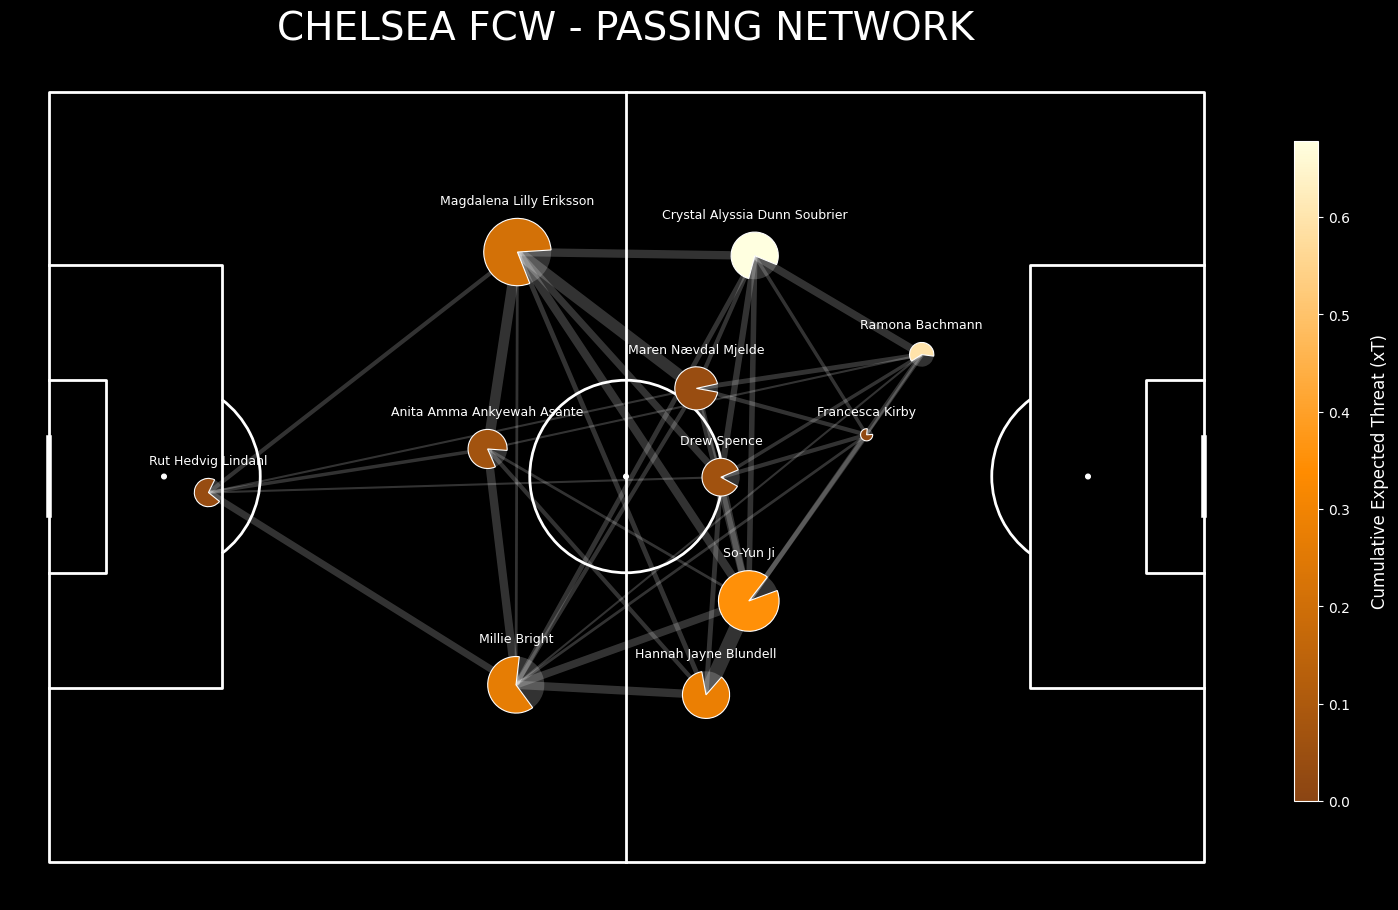

In [45]:
match_id = 7298

base_path ="/home/liyi/Documents/project_kick/kick_lab/data/statsbomb_open_data/data"

df_clean_passes = prepare_filtered_passes(base_path, match_id)

plot_passing_network(df_clean_passes, team_name=df_clean_passes['team_name'].iloc[0])